<center><img src=img/MScAI_brand.png width=70%></center>

# Grammars

A **grammar** is a computational device which can:
* *generate* strings from a given formal language, or
* *parse* strings to check that they come from a given language.

There are a few different types of grammar, but we will only study the **context-free grammar**, written in the **Backus-Naur Form** (BNF) notation.

A grammar is a set of *rewrite rules*. Here is an example in BNF:

```
<sentence>     ::= <noun_phrase> <verb_phrase>
<noun_phrase>  ::= <noun> | <determiner> <noun>
<determiner>   ::= the | a
<noun>         ::= lion | tiger | antelope
<verb_phrase>  ::= <trans_verb> <noun_phrase> | <intrans_verb>
<trans_verb>   ::= ate | saw | chased
<intrans_verb> ::= slept | rested
```

But we will stick to formal languages. Here's another example:
```
<expr> ::= (<expr> <biop> <expr>) 
           | <uop> <expr> | <var> | <const>
<biop> ::= and | or
<uop> ::= not
<var> ::= x[0] | x[1] | x[2]
<const> ::= True | False
```

Each rule has a left-hand side and a right-hand side separated by the symbol `::=` interpreted as *rewrites to*. 

The LHS is a single string enclosed in angle brackets. 

The RHS consists of one or more *productions*, separated by the pipe symbol `|`, interpreted as "or". 

E.g., `<const>` *rewrites to* either `True` or `False`.

A *non-terminal* is a string enclosed in angle brackets. A *terminal* is any other string. The LHS is always a *non-terminal*, so it can rewrite to something.

One of the non-terminals is the *start symbol*. In our convention, the non-terminal of the first rule is the start symbol.

### Parsing a string

Parsing a string means starting with a string, and iteratively finding out what rule could have given rise to it, until either:

* We find the complete structure -- a *parsing* -- of the string, showing that it is a valid string in the language; or
* We find that the string is not in the language.

Compilers and interpreters use grammars in this way, e.g. the Python interpreter **parses** your code using a grammar. You can see the Python grammar here: https://docs.python.org/3/reference/grammar.html.

Recall that a piece of Python code corresponds to an Abstract Syntax Tree, like the one shown here. When we say that the Python interpreter parses a piece of code according to the Python grammar, and **finds its structure**, what we mean is that it creates an AST.

<center><img src=img/ast.svg width=35%></center>



### Generating a string from a grammar

Going in the opposite direction also has many applications in AI (we'll see one shortly). By this we mean starting with a grammar and generating a random string from the language:


1. We start with a *derivation* (a string) consisting of just the start symbol;
2. We find the first (left-most) non-terminal in the derivation, and find the rule where that non-terminal is the LHS.
3. We choose one of the productions on the RHS of that rule, and in the derivation, replace the non-terminal with that production.
4. If there are now no non-terminals in the derivation, we stop, else go to 2.

For example (just making **random** choices at each step):
1. `   <expr>`
2. `-> (<expr> <biop> <expr>)`
3. `-> (<var> <biop> <expr>)`
4. `-> (x[0] <biop> <expr>)`
5. `-> (x[0] and <expr>)`
6. `-> (x[0] and <const>)`
7. `-> (x[0] and False)`

The result is a string in the language. We see that this grammar defines a language consisting of Boolean expressions in up to three variables.

### Implementing a grammar for generating strings

We'll implement a grammar as a `dict`. Each rule gives a key-value pair where the key is the rule LHS and the value is a list of productions:

In [1]:
G = {
    "<expr>" : [["(", "<expr>", "<biop>", "<expr>", ")"], 
                ["<uop>", "<expr>"], ["<var>"], ["<const>"]],
    "<biop>" : [["and"], ["or"]],
    "<uop>"  : [["not"]],
    "<var>"  : [["x[0]"], ["x[1]"], ["x[2]"]],
    "<const>": [["True"], ["False"]]
}

### Deriving a (random) string

In [9]:
import random
def derive_random_str(G, start):
    if start in G: # start is a non-terminal
        return " ".join(derive_random_str(G, p) 
                        for p in random.choice(G[start]))
    else: # start is a terminal
        return start

We'll see lots of strings, all valid Python.

In [10]:
for i in range(10):
    print(derive_random_str(G, "<expr>"))

False
not x[2]
not x[2]
( True and ( ( not x[0] or x[0] ) and x[2] ) )
not not x[2]
x[0]
True
x[1]
( x[0] or False )
not True


In fact, we can even turn a string into a piece of code, using `eval` as before, and then run it with appropriate arguments:

In [11]:
for i in range(10):
    s = derive_random_str(G, "<expr>")
    f = eval("lambda x: " + s)
    # run our new function with some arguments x
    x = (False, True, False)
    print(s, ":", f(x)) 

True : True
False : False
( ( not ( not x[2] and x[0] ) or ( False or ( x[2] and x[2] ) ) ) or not not False ) : True
( True or ( True or ( True or not True ) ) ) : True
not True : False
( x[1] and x[0] ) : False
x[0] : False
not False : True
x[1] : True
False : False


### Generative art - by hand

Let's make a piece of generative art by inventing a formula $p(x, y)$ and simply plotting $p$ over the unit square.

$p$ should be purely numerical, e.g. $p(x, y) = \sin(20x)$. 

We'll use `linspace`, `meshgrid`, and `imshow` (recall our notebook/video on fractals in an earlier week) to make the grid. Here we won't iterate a formula and calculate escape time or anything like that.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [6]:
n = 200
xs = np.linspace(0, 1, n)
ys = np.linspace(0, 1, n)
x, y = np.meshgrid(xs, ys)

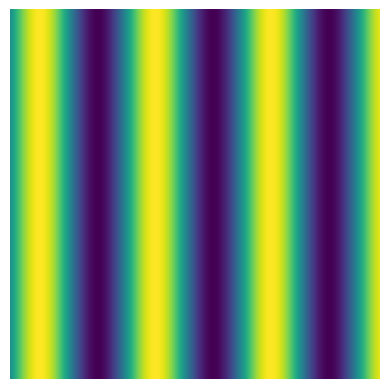

In [7]:
def p(x, y): return np.sin(20 * x) # sin(20x)
plt.axis('off'); plt.imshow(p(x, y), cmap=cm.viridis); 

### Generative art - using grammars

"I'd rather write programs that write programs than write programs" -- Richard Sites

Notice that we can also write functions like `p(x, y)` as pure strings, using `eval` as follows:

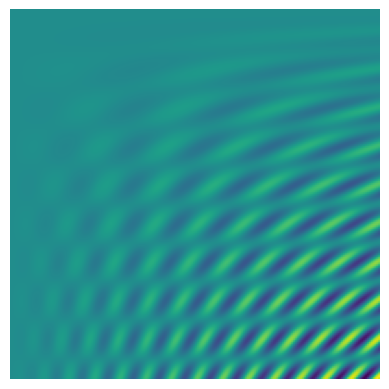

In [8]:
ps = "np.sin(90 * x * y) * np.sin(30 * (y+0.1)) * x * y"
p = eval("lambda x, y: " + ps)
plt.axis('off'); plt.imshow(p(x, y));

### Exercise

Make a new grammar `G` for *arithmetical expressions in x and y*. Start by copying the boolean grammar above. Generate random expressions from that, turn them into functions using `eval`, and visualise them, using the same code as above. Try out different colormaps with `cmap`. Think of some more interesting primitive functions to use other than `*`, `sin`, and friends. You can even create more variables (beyond $x$ and $y$), e.g. polar coordinates $r$ and $\theta$.